## SI 330 Lab 3: Indexing Dataframes

PLEASE REMEMBER TO **READ** THE TEXT AS YOU WORK ALONG, FROM TOP TO BOTTOM, WITH THIS NOTEBOOK!

In [16]:
### RUN THIS CELL FIRST
from interactive import si330_lab_questions
import pandas as pd
import numpy as np

### Part 1: Weather Across DateTimes 
#### Estimated Time: 20 min.

Before we begin, let's review the function `apply()` one last time. Consider the following dataframe `df` and four function definitions:

| Inventory  | Rupees (Buy) | Rupees (Sell) |
| ---------- | -----------  | ------------  |
| Amber      |    120       |     30        |
| Ironshroom |     20       |      5        |
| Cold Darner|      8       |      2        |
|Goron Spice |     16       |      4        |

![matching question 1](matching1.png)

Answer the following question correctly before moving on.

In [2]:
si330_lab_questions(0)

ValueError: only 2 non-keyword arguments accepted

The focus of today's lab will be on manipulating time series. The dataset consists of a single csv file. Information about this data can be found in the [pdf file](appliance_energyuse.pdf), which is the following paper:

[Candanedo, L. M., Feldheim, V., & Deramaix, D. (2017). Data driven prediction models of energy use of appliances in a low-energy house. Energy and buildings, 140, 81-97.](https://www.sciencedirect.com/science/article/abs/pii/S0378778816308970)

The data includes energy usage from a house (set up with temperature sensors, humidity sensors, and electric meters in multiple rooms) in Belgium over the course of ~4.5 months. It also contains information about the local weather as measured from the nearest airport weather station (Chièvres Airport,
Belgium; see figure). Descriptions of each variable may be found in **Table 2**.

![Belgium map](map.png)

First, complete `get_data()` by reading in the csv file. Then, make sure the date column is in a DateTime format, and that it is set as the index. Return the resulting *dataframe*.

Next, starting on the first date, write a function `get_outdoor_daily_temp()` to return a *series* with the average outdoor temperature in degrees Farenheit ($^\circ F$) for each day. Here's the conversion formula:

$$\bigg(C * \frac{9}{5}\bigg) + 32 = F$$

In [19]:
def get_data():
    df = pd.read_csv("energydata_complete.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

def get_outdoor_daily_temp(df):
    daily_temps = df.resample('D').mean()['T_out']
    daily_temps = daily_temps.apply(c_to_f)
    return daily_temps

def c_to_f(c):
    f = c * (9/5) + 32
    return f

get_outdoor_daily_temp(get_data()).head()

date
2016-01-11    42.660714
2016-01-12    42.019375
2016-01-13    40.742500
2016-01-14    38.177500
2016-01-15    36.797500
Freq: D, Name: T_out, dtype: float64

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


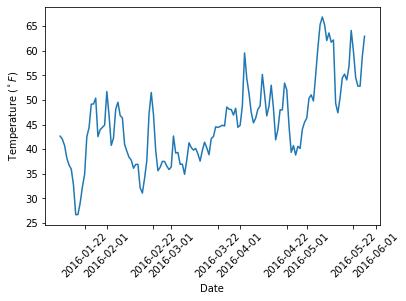

In [20]:
import matplotlib.pyplot as plt

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Temperature ($^\circ F$)')
plt.plot(get_outdoor_daily_temp(get_data()))

Is this plot as you expected? Make sure it looks reasonable before you continue on with part 2!

<h3><center>END OF PART 1</center></h3>

When you are done, **check your solution** with an instructor, or view the solution at **3:25 pm** for the **[matching question](https://drive.google.com/file/d/1SzrgOIXpdCUE-lAmpx61oWguwbAQISev/view?usp=sharing)** and **[get_outdoor_daily_temp](https://drive.google.com/file/d/1M4UuOyLqg4DKsvTxhI19yZwtBhwMcq5v/view?usp=sharing)**.

--------------------------------

### Part 2: Energy Usage and Billing

#### Estimated Time: 20 min.

Now we want to calculate this household's electric bill for each *business month* (exclude January and May), as those months are incomplete. Note: the first month would start on 2016-01-30 and the last month ends on 2016-04-29 (each "month" is exactly 30 days).

To do so, note that the average electricity rate in Belgium in 2016 was ~$27.5¢$ per kWh (1000 Wh = 1 kWh).
Return a dataframe with the total energy consumed (column named `energy`) and total cost (column named `cost`) for each billing cycle from January to April (the indices should be labeled with the FIRST DAY of the billing cycle). Hint: the docs for [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) might be useful!

In [24]:
import datetime

df = get_data()

def get_monthly_bill(df):
    df = df['2016-01-30':'2016-04-29'][['Appliances', 'lights']]
    df['energy'] = df['Appliances'] + df['lights']
    df = df.resample('BM', label = 'left').sum()
    df['cost'] = df['energy'] * (0.275 / 1000)
    return df
    

get_monthly_bill(df)

,Appliances,lights,energy,cost
date,,,,
2016-01-29,458980,28600,487580,134.0845
2016-02-29,432800,17480,450280,123.8270
2016-03-31,406980,10340,417320,114.7630


We want to see if the temperature outside is correlated with the electric bill. Recall that we have already written a function in part 1 that gives us a series with daily temperatures. So, let's write a function that utilizes the dataframe you just created, and *upsamples* to yield a dataframe with the same average daily energy usage and cost for each day (per given month).

Make sure that the dates range from 2016-01-29 to 2016-04-29! You will need to [reindex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reindex.html) using a new [date_range](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html).

In [26]:
df = get_data()
df = get_monthly_bill(df)

def extrapolate_daily_bill(df):
    quarter = pd.date_range('2016-01-29', '2016-04-29')
    df = df.reindex(quarter).resample('D').asfreq().divide(30).ffill()
    return df 

extrapolate_daily_bill(df).tail()

,Appliances,lights,energy,cost
2016-04-25,13566.0,344.666667,13910.666667,3.825433
2016-04-26,13566.0,344.666667,13910.666667,3.825433
2016-04-27,13566.0,344.666667,13910.666667,3.825433
2016-04-28,13566.0,344.666667,13910.666667,3.825433
2016-04-29,13566.0,344.666667,13910.666667,3.825433


(3.5, 4.8)

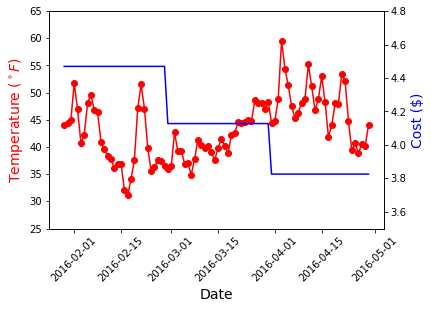

In [27]:
df = get_data()
daily_temp = get_outdoor_daily_temp(df)['2016-01-29':'2016-04-29']
daily_bill = extrapolate_daily_bill(get_monthly_bill(df))['cost']

fig,ax = plt.subplots()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.plot(daily_temp, color="red", marker="o")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Temperature ($^\circ F$)",color="red",fontsize=14)
ax.set_ylim(ymin=25, ymax=65)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(daily_bill,color="blue")
ax2.set_ylabel("Cost ($)",color="blue",fontsize=14)
ax2.set_ylim(ymin=3.5, ymax=4.8)

**BONUS** (preview for next class): The temperature plot is a bit messy due to the large variability. Let's try smoothing it out not by plotting the daily temperatures, but rather an average of the two daily temperatures before and after a particular day (including that date itself). See the diagram below.

![rolling window](window.png)

Return a series with these new values. Note: [Timedelta](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html) might come in particularly handy...

In [32]:
df = get_data()
temps = get_outdoor_daily_temp(df)

def get_smooth_temps(temps):
    smooth_temps = pd.Series()
    for date in temps.index:
        dates = [date + pd.Timedelta(days = x) for x in range(-2, 3)] 
        smooth_temps[date] = np.mean([temps.get(date, np.nan) for date in dates])
        return smooth_temps
    
get_smooth_temps(temps).head()

2016-01-11   NaN
dtype: float64

Now, try using the [rolling](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) function! It should help simplify this task.

In [33]:
df = get_data()
temps = get_outdoor_daily_temp(df)

def get_smooth_temps_with_rolling_window(temps):
    return temps.rolling(5, center = True).mean()

get_smooth_temps_with_rolling_window(temps).head()

date
2016-01-11          NaN
2016-01-12          NaN
2016-01-13    40.079518
2016-01-14    38.737250
2016-01-15    36.874750
Freq: D, Name: T_out, dtype: float64

(3.5, 4.8)

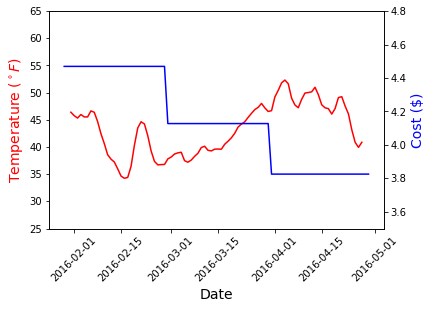

In [34]:
df = get_data()
daily_temp = get_outdoor_daily_temp(df)['2016-01-29':'2016-04-29']
smooth_temps = get_smooth_temps_with_rolling_window(daily_temp)
daily_bill = extrapolate_daily_bill(get_monthly_bill(df))['cost']

fig,ax = plt.subplots()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.plot(smooth_temps, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Temperature ($^\circ F$)",color="red",fontsize=14)
ax.set_ylim(ymin=25, ymax=65)
ax2 = ax.twinx()
ax2.plot(daily_bill,color="blue")
ax2.set_ylabel("Cost ($)",color="blue",fontsize=14)
ax2.set_ylim(ymin=3.50, ymax=4.80)

What do you notice about this new plot? What can you say about the relationship between energy costs and temperature (if any)?

<h3><center>END OF PART 2</center></h3>

When you are done, **check your solution** with an instructor, or view the solution at **3:45 pm** for **[get_monthly_bill](https://drive.google.com/file/d/1SGtAnTJm-bsKcQo4lohVzV8O5oAy3QOO/view?usp=sharing)** and **[extrapolate_daily_bill](https://drive.google.com/file/d/1aCPeE5GeeSmSWisZQHnwo7QhPCq6A1hv/view?usp=sharing)**.

Bonus solution for **[get_smooth_temps](https://drive.google.com/file/d/1ltqpIO_M9Y2rP5a3cEcjCD2iiwQnR3Ma/view?usp=sharing)**.

-----------------------------------

**For full lab completion points, commit and push your changes, and fill out the exit ticket.**